Lecturer: Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Ziwei Huang, Rita González Márquez

Summer term 2023

Name: FILL IN YOUR NAMES HERE

# Neural Data Science Project 02

## Working with Calcium data

In the following project you will recieve a data set, along with a set of questions. Use the methods that you have learned throughout this course to explore the data and to answer the questions. You are free to use tools, resources and libraries as you see fit. Use comments and markdown cells to document your thought process and to explain your reasoning. We encourage you to compare different algorithms or to implement state of the art solutions. The notebook should be self contained, although you may offload some functions to a `utils.py`. The notebook should be concluded with a final summary / conclusions section.

## Context
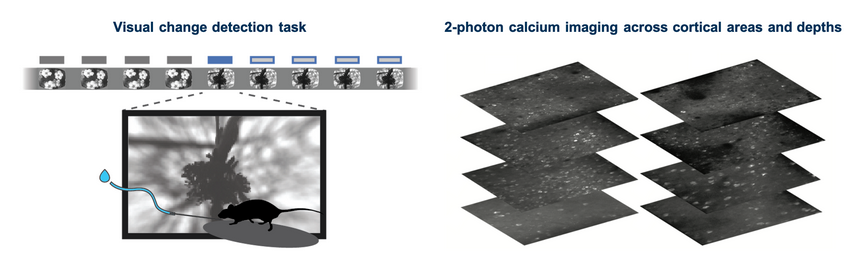

The data set that goes along with this notebook was recorded using in vivo 2-photon calcium imaging to measure the activity of genetically identified neurons in the visual cortex of mice performing a go/no-go visual change detection task. The data recordings stem from primary visual cortex and a GCaMP6f indicator was used. The data was recorded as follows.

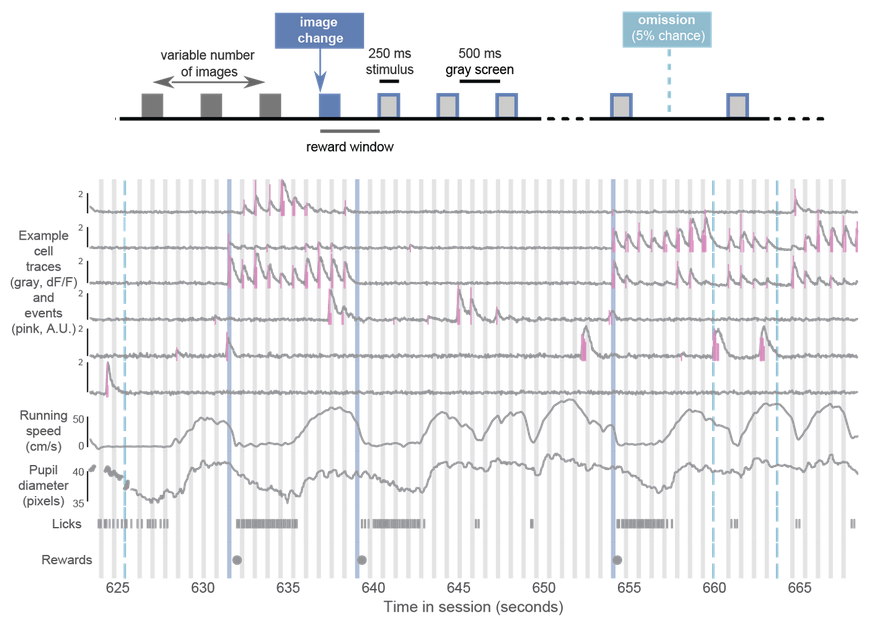

The data consists of:
- the preprocessed activity traces (df/f)
- the stimulus metadata
- the stimulus frames
- the ROI masks for each cell
- a maximum activity projection of all ROIs
- running speed
- table of stimulus epochs

You will only work with a locally sparse noise stimulus.

Since the experiments were performed in sequence the calcium recordings that you receive also contain some other stimulus modalities (see `data["stim_epoch_table"]`). You can ignore these sections of the time-series data during analysis. Not all the data provided has to be used, however it can be incorporated into your analysis.

### Question session #1
- Dataset paper link? 

https://portal.brain-map.org/explore/circuits/visual-behavior-2p
- Maximum activity projection? 

*Just plot it*
- ROI?
- Features in stimulus metadata?
- What do licks mean? What does mouse get reward for? PAPER PAPER PAPER PAPER



### Question session #2
- What is spatial structure? Is it in the brain? Or in spatial location of a visual stimulus?
- Cell types mentioned - no data on them

## Imports

In [3]:
# import packages here

import numpy as np
import pandas as pd
from scipy import signal, stats

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
data_path = Path("../data/")

In [95]:
# load data
def load_data(path="."):
    def array2df(d, key, cols):
        d[key] = pd.DataFrame(d[key], columns=cols)

    data = np.load(path / "dff_data_rf.npz", allow_pickle=True)
    data = dict(data)
    array2df(data, "stim_table", ["frame", "start", "end"])
    array2df(data, "stim_epoch_table", ["start", "end", "stimulus"])

    return data


def print_info(data):
    data_iter = ((k, type(v), v.shape) for k, v in data.items())
    l = [f"[{k}] - {t}, - {s}" for k, t, s in data_iter]
    print("\n".join(l) + "\n")

from pathlib import Path
data_path = Path("../data/")

data = load_data(data_path)

print("Overview of the data")
print_info(data)

Overview of the data
[t] - <class 'numpy.ndarray'>, - (105968,)
[dff] - <class 'numpy.ndarray'>, - (189, 105968)
[stim_table] - <class 'pandas.core.frame.DataFrame'>, - (8880, 3)
[stim] - <class 'numpy.ndarray'>, - (9000, 16, 28)
[roi_masks] - <class 'numpy.ndarray'>, - (189, 512, 512)
[max_projection] - <class 'numpy.ndarray'>, - (512, 512)
[running_speed] - <class 'numpy.ndarray'>, - (2, 105968)
[stim_epoch_table] - <class 'pandas.core.frame.DataFrame'>, - (7, 3)



In [107]:
times = data['t'].copy()
dff = data['dff'].copy()
stim_table = data['stim_table'].copy()
stim = data['stim'].copy()
roi = data['roi_masks'].copy()
max_projection = data['max_projection'].copy()

n_neurons, n_times = dff.shape
stim_shape = stim[0].shape
n_stim = stim_table.shape[0]
roi_shape = max_projection.shape

print(f"Max time: {times[-1]}")
print(f"Number of neurons: ", n_neurons)
print("Stimulus frame shape: ", stim_shape)
print("Number of presented stimuli: ", n_stim)

Max time: 3524.5851
Number of neurons:  189
Stimulus frame shape:  (16, 28)
Number of presented stimuli:  8880


## Question

**Is there spatial structure on the location of the receptive fields?** 

Implement all steps of the processing pipeline that are necessary to answer them. Think of: 
1. Pre-processing 
2. Spike inference 
3. Tuning function fitting 
4. Statistical testing. 

It is sufficient to assess spatial structure visually. Bonus points for proper statistical assessment. Also bonus points if you focus on specific cell types.

## Data exploration

### Stimuli

#### Dataframes with descriptions

In [6]:
data['stim_table']

,frame,start,end
0,0,737,744
1,1,745,752
2,2,752,759
3,3,760,767
4,4,767,774
...,...,...,...
8875,8875,105705,105712
8876,8876,105712,105719
8877,8877,105720,105727
8878,8878,105727,105734


In [9]:
data['stim_epoch_table']

,start,end,stimulus
0,locally_sparse_noise,737,22461
1,spontaneous,22611,31520
2,natural_movie_one,31521,40571
3,locally_sparse_noise,41476,63199
4,natural_movie_two,64105,73156
5,spontaneous,73306,82207
6,locally_sparse_noise,82208,105742


#### Example stimuli

Minimal value of a pixel:  0
Maximal value of a pixel:  255


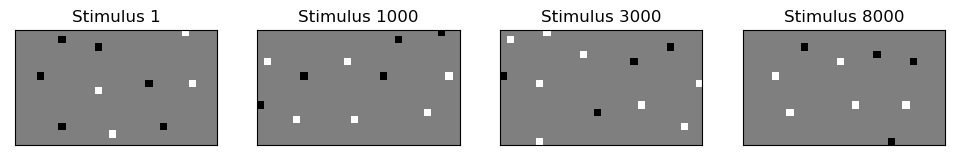

In [78]:
stim_indices = [1, 1000, 3000, 8000]
fig, axes = plt.subplots(1, len(stim_indices), figsize=(len(stim_indices) * 3, 3))
for i, i_stim in enumerate(stim_indices):
    ax = axes[i]
    ax.set_title(f"Stimulus {i_stim}")
    ax.imshow(stim[i_stim], cmap='gray')
    ax.set_xticks([]); ax.set_yticks([]);
print("Minimal value of a pixel: ", np.min(stim[i_stim]))
print("Maximal value of a pixel: ", np.max(stim[i_stim]))

Let's convert the values of the pixels to the normalized range from $-1$ to $+1$. This way if pixel is not activated, in the original data it will take value equals $127$, which will be transformed into $0$. If it was black, it will take value $0$, which is converted to $-1$, and $255$ will be converted to $+1$.

In [115]:
stim = stim.astype(int)
stim[stim == 0]   = -1
stim[stim == 127] = 0
stim[stim == 255] = 1
np.unique(stim)

array([-1,  0,  1])

#### Distribution of a single pixel

Probability of different stimulus values across image presentations: 
-1: 0.0131
0: 0.9749
1: 0.0120


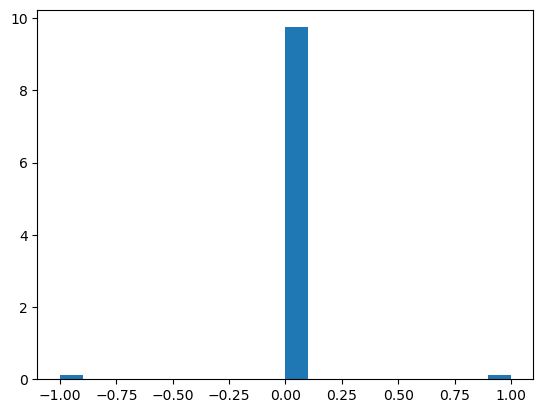

In [118]:
p0, p1 = (5, 5) # pixel coordinates
pixel_vals = stim[:, p0, p1]
print("Probability of different stimulus values across image presentations: ")
for val in [-1, 0, 1]:
    print(f"{val}: {np.sum(pixel_vals == val) / pixel_vals.size:.4f}")
plt.hist(pixel_vals, bins=20, density=True);

## Calcium imaging

### Locations

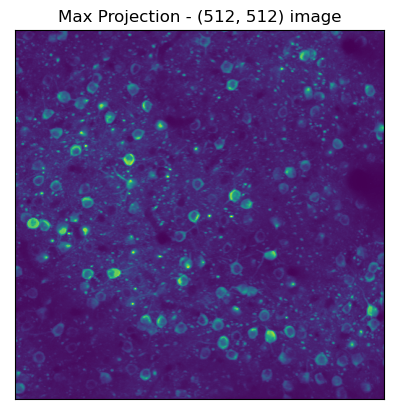

In [10]:
plt.imshow(data['max_projection'])
plt.title("Max Projection - (512, 512) image");
plt.xticks([]); plt.yticks([]);

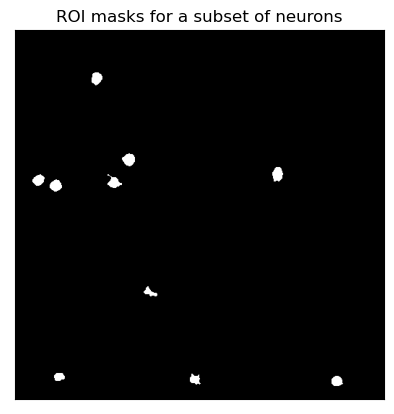

In [46]:
roi_layers = np.zeros(roi_shape)
for neuron in range(0, 100, 10):
    roi_layers += roi[neuron]
plt.imshow(roi_layers, cmap='gray')
plt.title("ROI masks for a subset of neurons")
plt.xticks([]); plt.yticks([]);

Let's look at the location mask in more detail.
For this let's find values of $x$ and $y$, which are defining the borders of ROI - this will allow to zoom in the ROI mask automatically.

In [52]:
list(range(0, 100, 10))

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90]

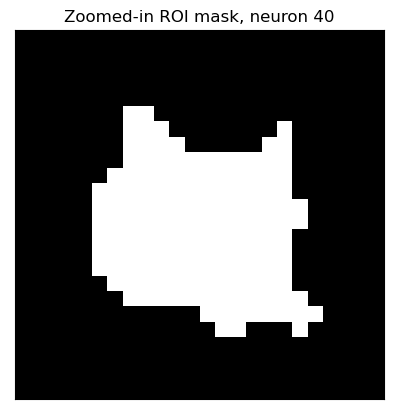

In [56]:
neuron = 40
roi_example = roi[neuron]
x_nonzero = np.nonzero(roi_example.sum(axis=0))[0]
y_nonzero = np.nonzero(roi_example.sum(axis=1))[0]
xmin, xmax = x_nonzero[0] - 5, x_nonzero[-1] + 5
ymin, ymax = y_nonzero[0] - 5, y_nonzero[-1] + 5

plt.title(f"Zoomed-in ROI mask, neuron {neuron}")
plt.imshow(roi_example[ymin:ymax, xmin:xmax], cmap='gray')
plt.xticks([]); plt.yticks([]);